# Drawing from Conditional Density

For our utility loss estimate, we need to draw from the joint prior distribution conditioned on one's own valuation. The utility loss is defined as

$$L_\text{utility}(b) \; = \; \max_{v_i \in \mathcal{V_i}} \, \max_{b_i^* \in \mathcal{A_i}} \, E_{v_{-i}|v_i}\left[u(v_i,b_i^*,b_{-i}(v_{-i}))-u(v_i,b_i,b_{-i}(v_{-i}))\right],$$

where we take the maximum utility increase over all possible actions (on a grid) and take the maximum over all our valuations. This expectation has to be drawn over $(v_{-i}|v_i)$.

The current implementation assumes independence of the $v_i$'s and just samples each component individually, causing a systemnatic bias when there are dependencies.

In [1]:
# imports
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import torch

# Affiliated information setting
### Sample from original distribution
__Krishna__: Suppose $S_1$, $S_2$, and $T$ are uniformly and independently distributed on $[0,1]$. There are two bidders. Bidder $1$ receives the signal $X_1 = S_1 + T$, and bidder $2$ receives the signal $X_2 = S_2 + T$. The object has a common value $$V = \frac{1}{2}(X_1 + X_2).$$

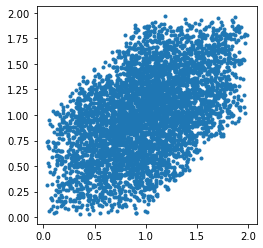

In [2]:
n_samples = 5000
Omega = torch.zeros((n_samples, 3)).uniform_(0, 1)
X_1 = Omega[:, 0] + Omega[:, 2]
X_2 = Omega[:, 1] + Omega[:, 2]

ax = plt.gca()
plt.plot(X_1, X_2, '.')
ax.set_aspect('equal', 'box')
plt.show()

---
# Light weight approach
We have $o_2|o_1 = u_1|o_1 + t|o_1$, where $u_1|o_1=u_1$ and $$t|o_1 = o_1 - u_1 \sim \mathcal U(\max(0, o_1-1), \min(1, o_1)).$$

In [3]:
def draw_common_given_o1(o1: torch.Tensor, batch_size: int):
    """
    Sample common signal conditioned on one agent's observation.
    Returns tensor of shape (v1.shape[0], batch_size).
    """
    batch_size_0 = o1.shape[0]
    batch_size_1 = batch_size

    l_bounds = torch.max(torch.zeros_like(o1), o1 - 1) \
        .repeat(batch_size_1, 1).view(batch_size_0, batch_size_1)
    u_bounds = torch.min(torch.ones_like(o1), o1) \
        .repeat(batch_size_1, 1).view(batch_size_0, batch_size_1)
    uniform = torch.empty((1, batch_size_1), device=o1.device).uniform_(0, 1) \
        .repeat(1, batch_size_0).view(batch_size_0, batch_size_1)
    return (u_bounds - l_bounds) * uniform + l_bounds

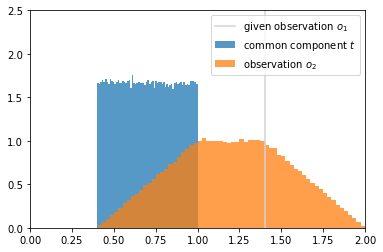

In [29]:
o1 = torch.tensor([1.4])
t = draw_common_given_o1(o1, 200000)
o2 = t + torch.empty_like(t).uniform_(0, 1)

plt.plot([o1, o1], [0, 10], color='lightgrey', label='given observation $o_1$')
plt.hist(t, 64, density=True, alpha=.75, label='common component $t$')
plt.hist(o2, 64, density=True, alpha=.75, label='observation $o_2$')
plt.xlim([0, 2]); plt.ylim([0, 2.5]); plt.legend()
plt.show()

---
# Deprecated: Conditional Sampleing
### Conditional on $X_1$, we want to sample $V$ and $X_2$ (where V depends on $X_2$)

In [5]:
def joint_density(X):
    """Joint density of the observations"""
    result = torch.zeros_like(X[:, 0])

    mask_1 = torch.logical_and(X[:, 0] < X[:, 1], torch.logical_and(X[:, 0] < 1, X[:, 1] < 1))
    result[mask_1] = X[:, 0][mask_1]

    mask_2 = torch.logical_and(X[:, 0] >= X[:, 1], torch.logical_and(X[:, 1] < 1, X[:, 0] < 1))
    result[mask_2] = X[:, 1][mask_2]

    mask_3 = torch.logical_and(X[:, 0] > 1,
                              torch.logical_and(X[:, 1] < 1, X[:, 0] < X[:, 1] + 1))
    result[mask_3] = 1 + X[:, 1][mask_3] - X[:, 0][mask_3]

    mask_4 = torch.logical_and(X[:, 1] > 1,
                              torch.logical_and(X[:, 0] < 1, X[:, 1] < X[:, 0] + 1))
    result[mask_4] = 1 + X[:, 0][mask_4] - X[:, 1][mask_4]

    mask_5 = torch.logical_and(X[:, 0] >= X[:, 1], torch.logical_and(X[:, 0] > 1, X[:, 1] > 1))
    result[mask_5] = 2 - X[:, 0][mask_5]

    mask_6 = torch.logical_and(X[:, 1] >= X[:, 0], torch.logical_and(X[:, 1] > 1, X[:, 0] > 1))
    result[mask_6] = 2 - X[:, 1][mask_6]
    
    return result

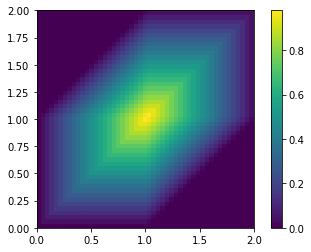

In [9]:
# generate 2 2d grids for the x & y bounds
n_samples = 50
y, x = np.meshgrid(np.linspace(0, 2, n_samples), np.linspace(0, 2, n_samples))
X = torch.tensor(np.concatenate((x.reshape(-1, 1), y.reshape(-1, 1)), 1))

fig, ax = plt.subplots()
c = ax.pcolormesh(x, y, joint_density(X).view(n_samples, n_samples))
fig.colorbar(c, ax=ax)
ax.set_aspect('equal', 'box')
plt.show()

In [11]:
def pdf_o2_cond_o1(o1):
    """Conditional PDF of observation 2 given observation 1"""
    def pdf(o2):
        result = torch.zeros_like(o2)

        mask_1 = o2 < o1
        result[mask_1] = o2[mask_1]

        mask_2 = torch.logical_and(o2 >= o1, o2 < 1)
        result[mask_2] = o1

        mask_3 = torch.logical_and(o2 < o1 + 1, o2 >= 1)
        result[mask_3] = 1 + o1 - o2[mask_3]

        return result
    
    if o1 < 1.0:
        f = 1 / o1
        return lambda o2: f * pdf(o2)
    else:
        o1 = 2 - o1
        f = 1 / o1
        return lambda o2: f * pdf(2 - o2)
    return pdf

def cdf_o2_cond_o1(o1):
    """Conditional CDF of observation 2 given observation 1"""

    def cdf(o2):
        result = torch.zeros_like(o2)

        mask_0 = o2 < 0
        result[mask_0] = 0
        
        mask_1 = torch.logical_and(o2 >= 0, o2 < o1)
        result[mask_1] = (1/(2*o1)) * torch.pow(o2[mask_1], 2)

        mask_2 = torch.logical_and(o2 >= o1, o2 < 1)
        result[mask_2] = -0.5*o1 + o2[mask_2]
        
        mask_3 = torch.logical_and(o2 >= 1, o2 < 1 + o1)
        result[mask_3] = -0.5 * o1 + 1 + ((1+o1-(o2[mask_3]+1)/2)/o1) * (o2[mask_3] - 1)
        
        mask_4 = o2 >= 1 + o1
        result[mask_4] = 1
        
        return result

    if o1 < 1.0:
        return lambda o2: cdf(o2)
    else:
        o1 = 2 - o1
        return lambda o2: cdf(o2 - (1-o1))

def icdf_o2_cond_o1(o1):
    """Conditional iCDF of observation 2 given observation 1"""
    o1_flat = o1.view(-1, 1)
    cond_batch = o1_flat.shape[0]

    def icdf(x):
        sample_batch = x.view(-1, 1).shape[0]
        xx = x.repeat(1, cond_batch).view(cond_batch, -1)
        oo1 = o1_flat.repeat(1, sample_batch)
        result = torch.zeros_like(xx)

        mask_0 = oo1 > 1.0
        oo1[mask_0] = 2 - oo1[mask_0]

        mask_1 = xx < 0.5*oo1
        result[mask_1] = torch.sqrt(2*oo1[mask_1] * xx[mask_1])

        mask_2 = torch.logical_and(xx >= 0.5*oo1, xx < 1 - 0.5*oo1)
        result[mask_2] = xx[mask_2] + 0.5*oo1[mask_2]

        mask_3 = xx >= 1 - 0.5*oo1
        result[mask_3] = -torch.sqrt(2*oo1[mask_3]*(-xx[mask_3] + 1)) + oo1[mask_3] + 1

        mask_4 = oo1 > 1
        result[mask_4] += oo1[mask_4] - 1

        result[mask_0] += (1 - oo1[mask_0])
        return result

    return icdf

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


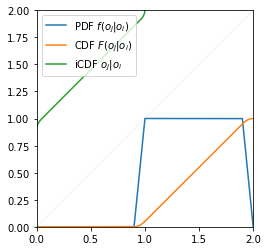

volume: 0.9999899864196777


In [14]:
fig, axs = plt.subplots(
    nrows=1, ncols=1, sharex=True,
    sharey=True,
    figsize=(10, 3.6)
)
o1 = torch.tensor(1.9)
n_samples = 100000
o2 = torch.linspace(0, 2, n_samples)

##
ax = axs
pdf = pdf_o2_cond_o1(o1)(o2)
cdf = cdf_o2_cond_o1(o1)(o2)
icdf = icdf_o2_cond_o1(o1)(o2).squeeze()
ax.plot(o2, o2, color='whitesmoke')
ax.plot(o2, pdf, label='PDF $f(o_j|o_i)$')
ax.plot(o2, cdf, label='CDF $F(o_j|o_i)$')
ax.plot(o2, icdf, label='iCDF $o_j|o_i$')
#ax.hist(icdf_o2_cond_o1(o1)(torch.tensor(np.random.uniform(0, 1, n_samples))),
#        50, color='lightgrey', density=True)
ax.set_xlim([0, 2.]); ax.set_ylim([0, 2.])
ax.legend(loc='upper left')
ax.set_aspect('equal', 'box')
plt.tight_layout()
plt.savefig('densities_affiliated.eps', transparent=True, pad_inches=0.0)
plt.show()

print('volume:', torch.mean(pdf).item() * 2)